In [ ]:
!pip install albumentations==0.4.6

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [3]:
import os
import tqdm
import cv2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [4]:
backbone = "efficientnet-b0"
img_height = 224 
img_width = 224 
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 10

In [5]:
device

device(type='cuda')

In [6]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [7]:
class LoadDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms, preprocess_fn):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.preprocess = get_preprocessing(preprocess_fn)
        self.images = sorted(next(os.walk(img_dir))[2])#[:200]
        self.masks = sorted(next(os.walk(mask_dir))[2])#[:200]
        self.class_values = [41, 76, 90, 124, 161]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(f"{self.img_dir}/{self.images[index]}").astype("uint8")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f"{self.mask_dir}/{self.masks[index]}", 0).astype("uint8")
        if self.transforms:
            sample = self.transforms(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']

        mask = np.stack([(mask == v) for v in self.class_values], axis=-1).astype('uint8')
        if self.preprocess:
            sample = self.preprocess(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']
        return image, mask

In [8]:
transform = A.Compose([A.Resize(height=img_height, width=img_width)])
preprocess_fn = smp.encoders.get_preprocessing_fn(backbone, pretrained='imagenet')
data = LoadDataset("imgs/", "masks/", transform, preprocess_fn)
train_size = int(0.7 * len(data))
train_data, val_data = random_split(data, [train_size, int(len(data) - train_size)])

In [9]:
len(train_data), len(val_data)

(700, 300)

In [10]:
img, mask = data[42]
img.shape, mask.shape

((3, 224, 224), (5, 224, 224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


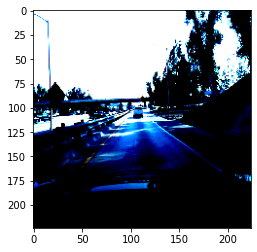

In [11]:
plt.imshow(img.transpose(1, 2, 0))

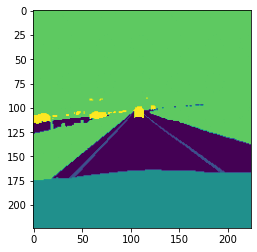

In [12]:
plt.imshow(mask.argmax(0))

In [13]:
train_batches = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_batches = DataLoader(val_data, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)

In [14]:
imgs, masks = next(iter(train_batches))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 5, 224, 224])


In [15]:
net = smp.Unet(backbone, classes=len(data.class_values), 
               activation=None, encoder_weights='imagenet').to(device)

In [16]:
inp = torch.randn(1, 3, img_height, img_width).to(device)
out = net(inp)
out.shape

torch.Size([1, 5, 224, 224])

In [17]:
opt = torch.optim.Adam(net.parameters(), lr=lr)
loss_fn = lambda preds, y: nn.CrossEntropyLoss()(preds, y.argmax(1))
get_accuracy = lambda preds, y: smp.utils.metrics.Accuracy(activation='softmax2d')(preds, y)

In [19]:
def loop(batches, net, is_train):
    batch_losses = []
    batch_accs = []
    if is_train:
        print("Train Loop:")
        print("")
        net.train()
    else:
        print("Validation Loop:")
        print("")
        net.eval()

    for X, y in tqdm.tqdm(batches, total=len(batches)):
        X = X.to(device)
        y = y.long().to(device)
        with torch.set_grad_enabled(is_train):
            preds = net(X)
            loss = loss_fn(preds, y)  
            acc = get_accuracy(preds, y)
        if is_train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        batch_losses.append(loss.item())
        batch_accs.append(acc)

    print("")
    print("")
    return sum(batch_losses) / len(batch_losses), sum(batch_accs) / len(batch_accs)

In [20]:
for epoch in range(epochs):
    train_loss, train_acc = loop(train_batches, net, True)
    val_loss, val_acc = loop(val_batches, net, False)
    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
    print("")

  0%|          | 0/22 [00:00<?, ?it/s]

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 0 | train_loss: 1.8032 | train_acc: 0.7852 | val_loss: 1.4714 | val_acc: 0.7864

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 1 | train_loss: 1.2496 | train_acc: 0.8263 | val_loss: 1.1278 | val_acc: 0.8433

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 2 | train_loss: 0.8174 | train_acc: 0.8985 | val_loss: 0.8338 | val_acc: 0.8983

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 3 | train_loss: 0.5544 | train_acc: 0.9478 | val_loss: 0.5856 | val_acc: 0.9438

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 4 | train_loss: 0.4181 | train_acc: 0.9689 | val_loss: 0.4474 | val_acc: 0.9659

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 5 | train_loss: 0.3418 | train_acc: 0.9754 | val_loss: 0.3575 | val_acc: 0.9733

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 6 | train_loss: 0.2933 | train_acc: 0.9784 | val_loss: 0.3108 | val_acc: 0.9761

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 7 | train_loss: 0.2601 | train_acc: 0.9801 | val_loss: 0.2783 | val_acc: 0.9774

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/22 [00:00<?, ?it/s]



epoch: 8 | train_loss: 0.2341 | train_acc: 0.9813 | val_loss: 0.2551 | val_acc: 0.9786

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



100%|██████████| 10/10 [00:09<00:00,  1.09it/s]



epoch: 9 | train_loss: 0.2115 | train_acc: 0.9827 | val_loss: 0.2397 | val_acc: 0.9792



In [23]:
def segment_images(img_ids):
    print("Displaying images:")
    net.eval()
    for img_id in img_ids:
        x = torch.tensor(train_data[img_id][0]).unsqueeze(0).to(device)
        gt = torch.tensor(train_data[img_id][1]).argmax(0)
        with torch.no_grad():
            pred = net(x)

        pred = pred.softmax(1).argmax(1)
        plt.imshow(x[0].permute(1, 2, 0).cpu())
        plt.show()
        plt.imshow(gt)
        plt.show()
        plt.imshow(pred[0].detach().cpu())
        plt.show()
        print("")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying images:


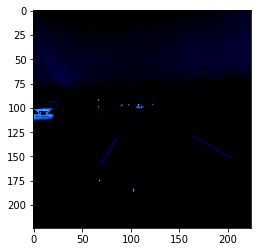

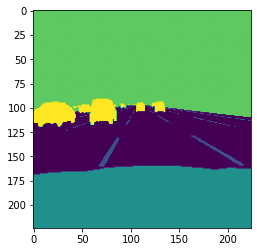

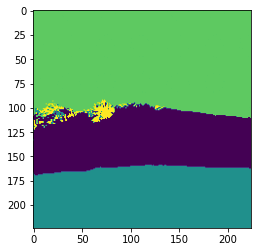

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


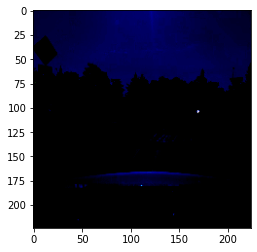

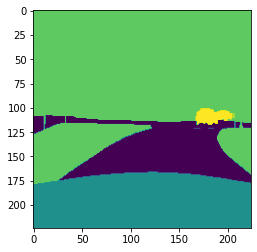

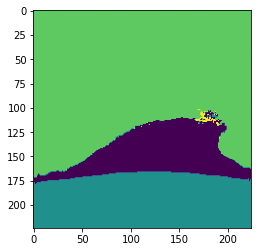

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


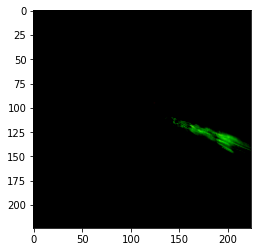

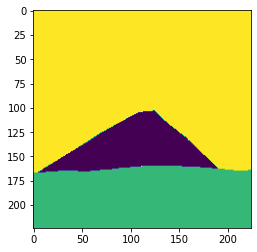

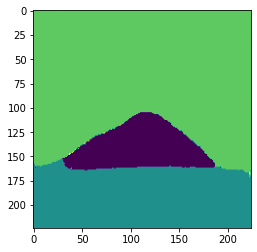

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


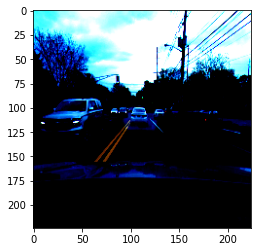

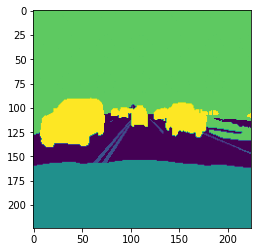

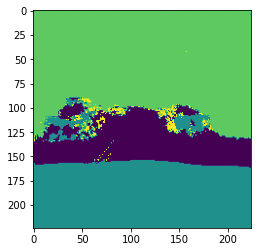

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


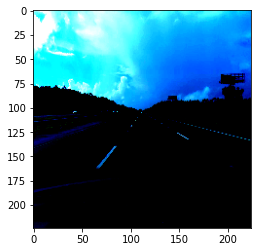

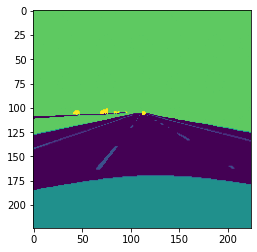

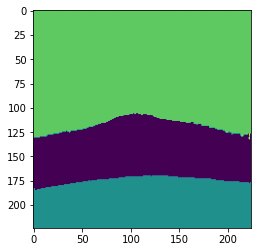

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


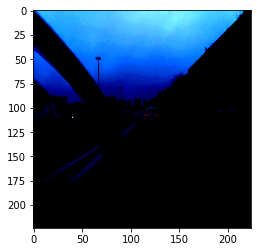

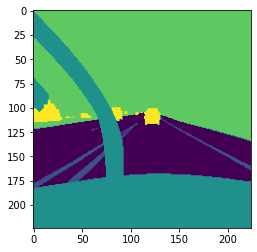

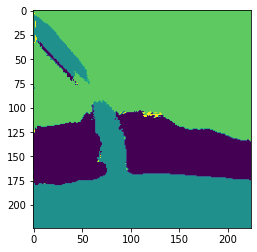

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


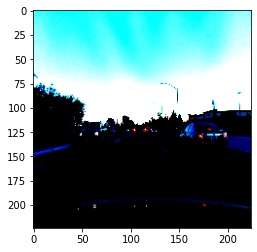

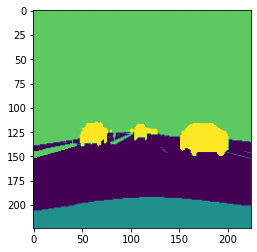

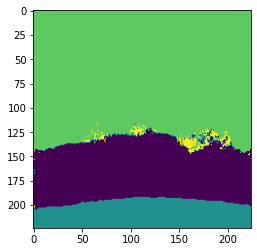

In [24]:
segment_images([4, 20, 42, 69, 100, 142, 242]) # results are obviously bad because the NN is trained on only 700 images due to GPU constraints, original dataset contains 9000 images

In [ ]:
# the NN acheives very high accuracy(97) because it was able to classify the background and the road correctly, but it needs to be trained on more images for better results